# Introduction

Email: alecgfox@gmail.com

[arXiv.org](https://arxiv.org/) is an open-access e-print archive for research-level math articles operated by Cornell University, and today almost all research-level results find their way to the site. To submit an article to arXiv.org, the author must have a university affiliation or be endorsed.
Opposed to this closed submission process, Philip Gibbs created [viXra.org](https://vixra.org/), an e-print archive which allows anyone to submit articles.
Unfortunately, viXra.org has become synonymous with pseudomathematics and mathematical crankery, articles which do not adhere to mathematical rigor and which often contain fallacies.
Mathematical crankery lies in contrast with genuine, but incorrect, attempts at a proof in that the authors may be deceitful in their presentation, or reprove already known results, or refuse to address mistakes.
Common topics of mathematical crankery are longstanding open problems like the Riemann hypothesis, P versus NP, Goldbach's conjecture, or the Collatz Conjecture, and refutations of well-established results like Godel's incompleteness theorems.

At the same time, arXiv.org's submission requirements are not perfect, and sometimes mathematical crankery appears on arXiv.org. When this occurs, often a moderator will move the article to the math.GM category (which stands for General Mathematics). This puts the math.GM category in a unique situation of containing a significant proportion of both legitimate research-level math and mathematical crankery.

We fine-tune BERT models to categorize articles from math.GM (based on their title, abstract, and number of authors) as more likely to be a legitimate research-level article (what we call high quality with label 0) or more likely to be mathematical crankery (what we call low quality with label 1). For the training data, we label articles from viXra.org as low quality, and articles from arXiv.org not belonging to math.GM (what we call arXiv.org proper) as high quality. Although there are some research-level articles on viXra.org, and, as we've discussed, mathematical crankery on arXiv.org, we make the assumption that these make up a relatively low proportion of the total data. More accurately, we are building a classifier to categorize if an article is styled more in the vein of viXra articles or in the vein of arXiv articles. We make the assumption that this categorization can be interpreted as a representation of the quality.

Below is the predictions of the models we built on the articles from math.GM. In each case, we see there is a bimodal distribution which supports what we know about math.GM. 
<center><img src="predictions_on_arxiv_gm.png"></center>
We also determine an optimal threshold for the classifier and categorize the articles.
<center><img src="classification_of_arxiv_gm.png"></center>

## Imports

In [2]:
import requests
from bs4 import BeautifulSoup
import pyodbc
from oaipmh.client import Client
from oaipmh.metadata import MetadataRegistry, oai_dc_reader

from unidecode import unidecode

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import time
import datetime
import re
import os
import itertools

from IPython.display import clear_output

## SQL Server (Google Cloud SQL) set up

We run [Cloud SQL Auth Proxy](https://github.com/GoogleCloudPlatform/cloud-sql-proxy) locally and then connect through the proxy to the SQL Server hosted in Google's Cloud SQL.

In [3]:
SQL_SERVER_Driver = "{ODBC Driver 18 for SQL Server}"
SQL_SERVER_Server = "127.0.0.1"
SQL_SERVER_Database = "project"
SQL_SERVER_UID = "sqlserver"
SQL_SERVER_PWD = "sqlserver"

cnxn = pyodbc.connect(f"DRIVER={SQL_SERVER_Driver};"
                      f"SERVER={SQL_SERVER_Server};"
                      f"DATABASE={SQL_SERVER_Database};"
                      f"UID={SQL_SERVER_UID};"
                      f"PWD={SQL_SERVER_PWD};"
                      f"TRUSTSERVERCERTIFICATE=yes;")
cursor = cnxn.cursor()
cursor.fast_executemany = True
cursor.execute("SELECT @@VERSION").fetchall()

[('Microsoft SQL Server 2019 (RTM-CU19) (KB5023049) - 15.0.4298.1 (X64) \n\tJan 27 2023 16:44:09 \n\tCopyright (C) 2019 Microsoft Corporation\n\tStandard Edition (64-bit) on Linux (Ubuntu 18.04.6 LTS) <X64>',)]

We will be working with two sets of tables to store collected article metadata: one for viXra and one for arXiv.


For each viXra article, we record the unique identifier `vixra_articles.vixra_identifier`, the title of the article `vixra_articles.title`, the abstract of the article `vixra_articles.abstract`, the viXra category of the article, and the date when the article was last updated `vixra_articles.last_updated`.

viXra also assigns each author a unique url identifier, so we record that identifier `vixra_authors.url_identifier` and the unicode name of the author `vixra_authors.name`.

The table `vixra_articles_authors` then serves as a junction table to record the many to many relationship between `vixra_articles` and `vixra_authors`.

In [4]:
cursor.execute("""
    IF NOT EXISTS (
        SELECT *
        FROM INFORMATION_SCHEMA.TABLES
        WHERE TABLE_NAME = 'vixra_articles'
            AND TABLE_SCHEMA = 'dbo' 
        )
    BEGIN
        CREATE TABLE vixra_articles (
           id INT NOT NULL IDENTITY PRIMARY KEY,
           vixra_identifier VARCHAR(15) NOT NULL UNIQUE,
           title VARCHAR(255) NOT NULL,
           abstract VARCHAR(MAX) NOT NULL,
           category VARCHAR(6) NOT NULL,
           last_updated DATE NOT NULL,
           );
    END
""")

cursor.execute("""
    IF NOT EXISTS (
        SELECT *
        FROM INFORMATION_SCHEMA.TABLES
        WHERE TABLE_NAME = 'vixra_authors'
            AND TABLE_SCHEMA = 'dbo' 
        )
    BEGIN
        CREATE TABLE vixra_authors (
           id INT NOT NULL IDENTITY PRIMARY KEY,
           url_identifier VARCHAR(255) NOT NULL UNIQUE,
           name NVARCHAR(255) NOT NULL,
           );
    END
""")

cursor.execute("""
    IF NOT EXISTS (
        SELECT *
        FROM INFORMATION_SCHEMA.TABLES
        WHERE TABLE_NAME = 'vixra_articles_authors'
            AND TABLE_SCHEMA = 'dbo' 
        )
    BEGIN
        CREATE TABLE vixra_articles_authors (
           id INT NOT NULL IDENTITY PRIMARY KEY,
           article_id INT NOT NULL FOREIGN KEY REFERENCES vixra_articles(id),
           author_id INT NOT NULL FOREIGN KEY REFERENCES vixra_authors(id),
           CONSTRAINT VAA_UP UNIQUE (article_id, author_id)
           );
    END
""")

For each arXiv article, we will record the unique identifier `arxiv_identifier`, the title `title`, the abstract `abstract`, the primary arXiv category `primary_category`, and the date the article was last updated `last_updated`. Since arXiv has no unique identifier for authors, we will record the number of authors `author_count` as well. To facilitate collecting new article metadata, we also record the OAI-PMH datestamp `oai_datestamp` we recieved in the OAI-PMH metadata record for the article.

In [5]:
cursor.execute("""
    IF NOT EXISTS (
        SELECT *
        FROM INFORMATION_SCHEMA.TABLES
        WHERE TABLE_NAME = 'arxiv_articles'
            AND TABLE_SCHEMA = 'dbo' 
        )
    BEGIN
        CREATE TABLE arxiv_articles (
           id INT NOT NULL IDENTITY PRIMARY KEY,
           arxiv_identifier VARCHAR(35) NOT NULL UNIQUE,
           title VARCHAR(MAX) NOT NULL,
           abstract VARCHAR(MAX) NOT NULL,
           primary_category VARCHAR(7) NOT NULL,
           author_count INT NOT NULL,
           oai_datestamp DATE NOT NULL,
           last_updated DATE NOT NULL,
           );
    END
""")

# Data collection

We will scrape the article metadata from viXra.org and use arXiv.org's OAI-PMH API to collect the article metadata from arXiv.org.

Before we upload the article metadata to the database, we make sure to normalize the text of the title and the abtract. The normalization removes newlines, reduces all spaces to one space, strips the text, and then converts any unicode characters to their latin equivalent. The vast vast majority of articles are written in English, so any non-latin text will just be converted and then given to the BERT preprocessor.

In [6]:
def normalize_text(text):
    text = text.replace("\r\n", " ").replace("\n", " ")
    text = text.replace("\'", "'")
    text = " ".join(text.split())
    text = text.strip()
    text = unidecode(text)
    return text

## Web scraping viXra.org

We use BeautifulSoup4 to navigate the DOM and scrape the relevant information. Then we clean the information and insert it into the database. There is no mechanism to see if an article has been updated without manually checking, so we collect the metadata for every article and upsert.

In [7]:
HEADERS = {"User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/112.0"}
VIXRA_HOME_URL = "https://vixra.org/"
SCRAPE_DELAY_COEFF = 1

In [28]:

def vixra_scrape_categories(vixra_home_url, headers):
    vixra_home_response = requests.get(vixra_home_url, headers=headers)
    vixra_home_soup = BeautifulSoup(vixra_home_response.text, "lxml")
    vixra_html_categories = vixra_home_soup.find("h2", string="Mathematics").find_next().find_all("li")
    return {e.a["href"] : e.a.string for e in vixra_html_categories}

# Vixra articles are stored in blocks depending on their category and when they were submitted. 
def vixra_scrape_blocks(vixra_home_url, headers, scrape_delay_coeff):
    vixra_categories = vixra_scrape_categories(vixra_home_url, headers)
    vixra_blocks = {}
    for category in vixra_categories.keys():
        category_home_url = vixra_home_url + category + "/"
        
        # We record the time a response takes so we can adjust sleep timer to prevent overloading.
        start = time.time()
        category_home_response = requests.get(category_home_url, headers=headers)
        delay = time.time() - start

        category_home_soup = BeautifulSoup(category_home_response.text, "lxml")
        blocks = category_home_soup.find(string="Previous months:").find_parent("p").find_all("a")
        vixra_blocks[category] = [block["href"] for block in blocks]

        time.sleep(scrape_delay_coeff * delay)
    return vixra_blocks
        

def vixra_scrape(vixra_home_url, headers, scrape_delay_coeff):
    

    vixra_articles = []
    vixra_articles_authors = []
    # vixra_authors is a dictionary so we can ensure we aren't adding the same author multiple times.
    vixra_authors = {}
    
    vixra_blocks = vixra_scrape_blocks(vixra_home_url, headers, scrape_delay_coeff)
    
    for category in vixra_blocks.keys():
        # We use block_idx only to display progress in processing the block
        for block_idx, block in enumerate(vixra_blocks[category]):
            block_url = vixra_home_url + category + "/" + block

            
            start = time.time()
            block_response = requests.get(block_url, headers=headers)
            delay = time.time() - start

            block_soup = BeautifulSoup(block_response.text, "lxml")
            abstracts = block_soup.find_all("div", id="abstract")
            
            # From the abstract div we can determine all relevant article information
            for abstract in abstracts:
                entry_line = abstract.find_previous("p")
                article_id = entry_line.find("a").string.strip()
                article_title = abstract.find("h3").contents[0].strip()
                article_abstract = abstract.find_all("p")[1].contents[0].strip()
                article_last_updated = re.search("on (.*)", entry_line.find("i").string)[1].strip()

                vixra_articles.append((article_id, 
                                              article_title, 
                                              article_abstract, 
                                              category, 
                                              article_last_updated))

                authors = abstract.find_all("p")[0].find_all("a")
                links = [(article_id, author["href"]) for author in authors]
                vixra_articles_authors.extend(links)

                author_names = {author["href"] : author.string.strip() for author in authors}
                vixra_authors.update(author_names)  

                print(f"Category: {category}\nBlock: {block_idx}/{len(vixra_blocks[category]) - 1}\nArticle: {article_id}")
                clear_output(wait=True)

            time.sleep(scrape_delay_coeff * delay)
    
    return vixra_articles, vixra_articles_authors, list(vixra_authors.items())

vixra_articles, vixra_articles_authors, vixra_authors = vixra_scrape(VIXRA_HOME_URL, HEADERS, SCRAPE_DELAY_COEFF)

Category: math
Block: 140/140
Article: viXra:2305.0047


In [69]:
def vixra_clean_articles(vixra_articles):
    
    def get_date_object(date_string):
        date_format_one = re.compile("(0?[0-9]|[12][0-9]|3[01]) (Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec) ([0-9]{4})")
        date_format_two = re.compile("([0-9]{4})-(0[1-9]|1[0-2])-(0[0-9]|[12][0-9]|3[01]) ([01][0-9]|2[0-3]):([0-5][0-9]):([0-5][0-9])")
        if date_format_one.fullmatch(date_string):
            return datetime.datetime.strptime(date_string, "%d %b %Y").date()
        elif date_format_two.fullmatch(date_string):
            return datetime.datetime.strptime(date_string, "%Y-%m-%d %H:%M:%S").date()
        else:
            print("Unexpected date format!")
            print(date_string)
            assert(False)
    
    return [(vixra_identifier,
             normalize_text(title),
             normalize_text(abstract), 
             category,
             get_date_object(last_updated)) 
            for (vixra_identifier, title, abstract, category, last_updated) in vixra_articles]

def vixra_upsert_articles(vixra_articles, cursor):
    clean = vixra_clean_articles(vixra_articles)
    # for faster transcations, we structure the data on this end instead of using SQL variables
    to_upsert = [record + record + (record[0],) for record in clean]
    cursor.executemany("""    
        BEGIN TRANSACTION;
        INSERT INTO vixra_articles 
        (vixra_identifier, title, abstract, category, last_updated) 
        SELECT ?,?,?,?,?
        WHERE NOT EXISTS
        (
            SELECT 1 FROM vixra_articles WITH (UPDLOCK, SERIALIZABLE)
                WHERE vixra_identifier = ?
        );
        IF @@ROWCOUNT = 0
        BEGIN
            UPDATE vixra_articles
            SET title = ?,
                abstract = ?,
                category = ?,
                last_updated = ?
            WHERE vixra_identifier = ?       
        END
        COMMIT TRANSACTION;
    """, to_upsert)
    cursor.commit()


def vixra_insert_authors(vixra_authors, cursor):
    to_insert = [record + (record[0],) for record in vixra_authors]
    cursor.executemany("""
        INSERT INTO vixra_authors 
        (url_identifier, name) 
        SELECT ?, ?
        WHERE NOT EXISTS
        (
            SELECT 1 FROM vixra_authors WITH (UPDLOCK, SERIALIZABLE)
                WHERE url_identifier = ?
        );
    """, to_insert)
    cursor.commit()


def vixra_insert_articles_authors(vixra_articles_authors, cursor):
    cursor.executemany("""
        INSERT INTO vixra_articles_authors (article_id, author_id)
        SELECT vixra_articles.id, vixra_authors.id
        FROM vixra_articles
            CROSS JOIN vixra_authors
        WHERE vixra_articles.vixra_identifier = ?
            AND vixra_authors.url_identifier = ?
        AND NOT EXISTS
        (
            SELECT 1 FROM vixra_articles_authors WITH (UPDLOCK, SERIALIZABLE)
                WHERE article_id = vixra_articles.id
                    AND author_id = vixra_authors.id
        );
    """, vixra_articles_authors)
    cursor.commit()
    
vixra_upsert_articles(vixra_articles, cursor)
vixra_insert_authors(vixra_authors, cursor)
vixra_insert_articles_authors(vixra_articles_authors, cursor)

## via arXiv.org's OAI-PMH API

We use arXiv.org's OAI-PMH API to collect article metadata, and then upload that metadata to the database. It is very slow to retrieve records through the API, so we upload to the database in chunks as we go. The OAI-PMH API "math" set includes articles whose primary category is not math, so make sure to exclude those.

Thank you to arXiv for use of its open access interoperability.

In [35]:
ARXIV_OAI_PMH_BASE_URL = "http://export.arxiv.org/oai2?verb=Identify"
registry = MetadataRegistry()
registry.registerReader("oai_dc", oai_dc_reader)
oai_client = Client(base_url = ARXIV_OAI_PMH_BASE_URL, metadata_registry = registry)

In [40]:
def chunk_iterator(iterable, size):
    iterator = iter(iterable)
    for first in iterator:
        yield itertools.chain([first], itertools.islice(iterator, size -1))

arxiv_oai_math_categories = {
    "Mathematics - Algebraic Geometry" : "math.AG",
    "Mathematics - Algebraic Topology" : "math.AT",
    "Mathematics - Analysis of PDEs" : "math.AP",
    "Mathematics - Category Theory" : "math.CT",
    "Mathematics - Classical Analysis and ODEs" : "math.CA",
    "Mathematics - Combinatorics" : "math.CO",
    "Mathematics - Commutative Algebra" : "math.AC",
    "Mathematics - Complex Variables" : "math.CV",
    "Mathematics - Differential Geometry" : "math.DG",
    "Mathematics - Dynamical Systems" : "math.DS",
    "Mathematics - Functional Analysis" : "math.FA",
    "Mathematics - General Mathematics" : "math.GM",
    "Mathematics - General Topology" : "math.GN",
    "Mathematics - Geometric Topology" : "math.GT",
    "Mathematics - Group Theory" : "math.GR",
    "Mathematics - History and Overview" : "math.HO",
    "Computer Science - Information Theory" : "math.IT",
    "Mathematics - K-Theory and Homology" : "math.KT",
    "Mathematics - Logic" : "math.LO",
    "Mathematical Physics" : "math-ph",
    "Mathematics - Metric Geometry" : "math.MG",
    "Mathematics - Number Theory" : "math.NT",
    "Mathematics - Numerical Analysis" : "math.NA",
    "Mathematics - Operator Algebras" : "math.OA",
    "Mathematics - Optimization and Control" : "math.OC",
    "Mathematics - Probability" : "math.PR",
    "Mathematics - Quantum Algebra" : "math.QA",
    "Mathematics - Representation Theory" : "math.RT",
    "Mathematics - Rings and Algebras" : "math.RA",
    "Mathematics - Spectral Theory" : "math.SP",
    "Mathematics - Statistics Theory" : "math.ST",
    "Mathematics - Symplectic Geometry" : "math.SG",
}


def arxiv_prepare_article_record(oai_record):
    oai_record_map = oai_record[1].getMap()
    oai_header = oai_record[0]
    arxiv_identifier = oai_header.identifier().partition("oai:")[2].strip()
    title = normalize_text(oai_record_map["title"][0])
    abstract = normalize_text(oai_record_map["description"][0])
    oai_primary_category = oai_record_map["subject"][0]
    #Default value is "NMP" for Not Math Primary
    primary_category = arxiv_oai_math_categories.get(oai_primary_category, "NMP")
    oai_datestamp = oai_header.datestamp().date()
    last_updated = datetime.datetime.strptime(oai_record_map["date"][-1], "%Y-%m-%d").date()
    author_count = len(oai_record_map["creator"])
    
    return (arxiv_identifier,
            title,
            abstract,
            primary_category,
            author_count,
            oai_datestamp,
            last_updated)

# Sometimes blank records are returned
def arxiv_is_valid_oai_record(oai_record):
    if len(oai_record) >= 2 and oai_record[0] and oai_record[1]:
        return True
    return False

def arxiv_upload_articles(chunk_size, oai_client, cursor):
    
    most_recent_upload = cursor.execute("SELECT MAX(oai_datestamp) FROM arxiv_articles").fetchone()[0]
    if not most_recent_upload:
        most_recent_upload = datetime.date.min
    
    # We keep track of what we do or do not insert for display purposes.
    upsert_count = 0
    seen_count = 0
    
    oai_records_generator = oai_client.listRecords(metadataPrefix="oai_dc", set="math")
    for oai_records_chunk in chunk_iterator(oai_records_generator, chunk_size):    

        records = [record for record in oai_records_chunk]
        # To save time, we only try to upsert from the current or newer datestamp
        new_records = [record for record in records 
                       if arxiv_is_valid_oai_record(record) 
                       and record[0].datestamp().date() >= most_recent_upload]
        
        upserted_this_chunk = 0
        if new_records:
            # for faster transcations, we structure the data on this end instead of using SQL variables
            # filter out all articles with primary category not math
            to_upsert = [prepared + prepared + (prepared[0],) for prepared in 
                         (arxiv_prepare_article_record(record) for record in new_records)
                        if prepared[3] != "NMP"]
            cursor.executemany("""
                BEGIN TRANSACTION;            
                INSERT INTO arxiv_articles 
                (arxiv_identifier, title, abstract, primary_category, author_count, oai_datestamp, last_updated) 
                SELECT ?, ?, ?, ?, ?, ?, ?
                WHERE NOT EXISTS
                (
                    SELECT 1 FROM arxiv_articles WITH (UPDLOCK, SERIALIZABLE)
                        WHERE arxiv_identifier = ?
                );
                IF @@ROWCOUNT = 0
                BEGIN
                    UPDATE arxiv_articles
                    SET title = ?,
                        abstract = ?,
                        primary_category = ?,
                        author_count = ?,
                        oai_datestamp = ?,
                        last_updated = ?
                    WHERE arxiv_identifier = ?       
                END
                COMMIT TRANSACTION;
            """, to_upsert)
            cursor.commit()
            upserted_this_chunk = len(to_upsert)
            
        upsert_count += upserted_this_chunk
        seen_count += len(records) - upserted_this_chunk

        print(f"{upsert_count} records from a new oai datestamp upserted.")
        print(f"{seen_count} invalid or old records seen.")
        clear_output(wait=True)

# Need to use a relatively small chunk_size or pyoai breaks
chunk_size = pow(10,3)
arxiv_upload_articles(chunk_size, oai_client, cursor)

540 records from a new oai datestamp upserted.
592151 invalid or old records seen.


# Preliminary analysis of data

We conduct a preliminary analaysis of the data and examine some syntactical properties of the titles and abstracts.

In [50]:
sns.set_theme()
sns.set_style("whitegrid")

We load the data from the SQL servers into pandas DataFrames. In the following, `arxiv_df` contains all articles from arXiv not including those from math.GM (what we refer to as arXiv proper), `arxiv_gm_df` contains all arXiv math.GM articles, and `vixra_df` contains all viXra articles.

In [42]:
arxiv_data = cursor.execute("""
    SELECT title, abstract, primary_category, author_count, last_updated
    FROM arxiv_articles
    WHERE primary_category <> ?;
""", "math.GM").fetchall()
arxiv_df = pd.DataFrame.from_records(arxiv_data, columns = ["title", "abstract", "category", "author_count", "last_updated"])
arxiv_df["source"] = "arXiv"
print(f"arxiv_df : {len(arxiv_df.index)} rows")

arxiv_gm_data = cursor.execute("""
    SELECT title, abstract, primary_category, author_count, last_updated
    FROM arxiv_articles
    WHERE primary_category = ?;
""", "math.GM").fetchall()
arxiv_gm_df = pd.DataFrame.from_records(arxiv_gm_data, columns = ["title", "abstract", "category", "author_count", "last_updated"])
arxiv_gm_df["source"] = "math.GM"
print(f"arxiv_gm_df : {len(arxiv_gm_df.index)} rows")

vixra_data = cursor.execute("""
    SELECT title, abstract, category, author_count, last_updated
    FROM vixra_articles
        INNER JOIN 
            (
            SELECT a.id AS id, COUNT(b.id) AS author_count
            FROM vixra_articles a 
                INNER JOIN vixra_articles_authors b 
                ON a.id = b.article_id
            GROUP BY a.id
            ) AS vixra_author_counts
        ON vixra_articles.id = vixra_author_counts.id
""").fetchall()
vixra_df = pd.DataFrame.from_records(vixra_data, columns = ["title", "abstract", "category", "author_count", "last_updated"])
vixra_df["source"] = "viXra"
print(f"vixra_df : {len(vixra_df.index)} rows")

combined_df = pd.concat([arxiv_df, arxiv_gm_df, vixra_df], ignore_index=True)

arxiv_df : 518771 rows
arxiv_gm_df : 3401 rows
vixra_df : 8890 rows


To get a better visual representation, we don't work with the full set of data. Instead, we take a balanced sample.

In [43]:
def get_balanced_sample(df, class_name):
    groups = df.groupby(class_name)
    min_size = groups.size().min()
    return groups.apply(lambda x : x.sample(min_size)).reset_index(drop = True)

balanced_combined_df = get_balanced_sample(combined_df, "source")

We collect some syntactial properties of the title and abstract: namely, the length of the text, the proportion of text which consists of alphabetical characters, and the average word  length. For us, a word will be defined simply by the white space as a nontrivial portion of the text consists of non-alphabetical symbols.

In [44]:
def get_alpha_proportion(string):
    L = len(string)
    if L == 0:
        return 1
    return len([c for c in string if c.isalpha()])/L

def get_average_word_length(string):
    words = string.split()
    if len(words) == 0:
        return 0
    return np.mean([len(word) for word in words])


numeric_balanced_df = pd.DataFrame()
numeric_balanced_df["source"] = balanced_combined_df["source"]
numeric_balanced_df["author_count"] = balanced_combined_df["author_count"]
numeric_balanced_df["title_length"] = balanced_combined_df["title"].str.len()
numeric_balanced_df["title_proportion_alpha"] = balanced_combined_df["title"].map(get_alpha_proportion)
numeric_balanced_df["title_avg_word_length"] = balanced_combined_df["title"].map(get_average_word_length)
numeric_balanced_df["abstract_length"] = balanced_combined_df["abstract"].str.len()
numeric_balanced_df["abstract_proportion_alpha"] = balanced_combined_df["abstract"].map(get_alpha_proportion)
numeric_balanced_df["abstract_avg_word_length"] = balanced_combined_df["abstract"].map(get_average_word_length)

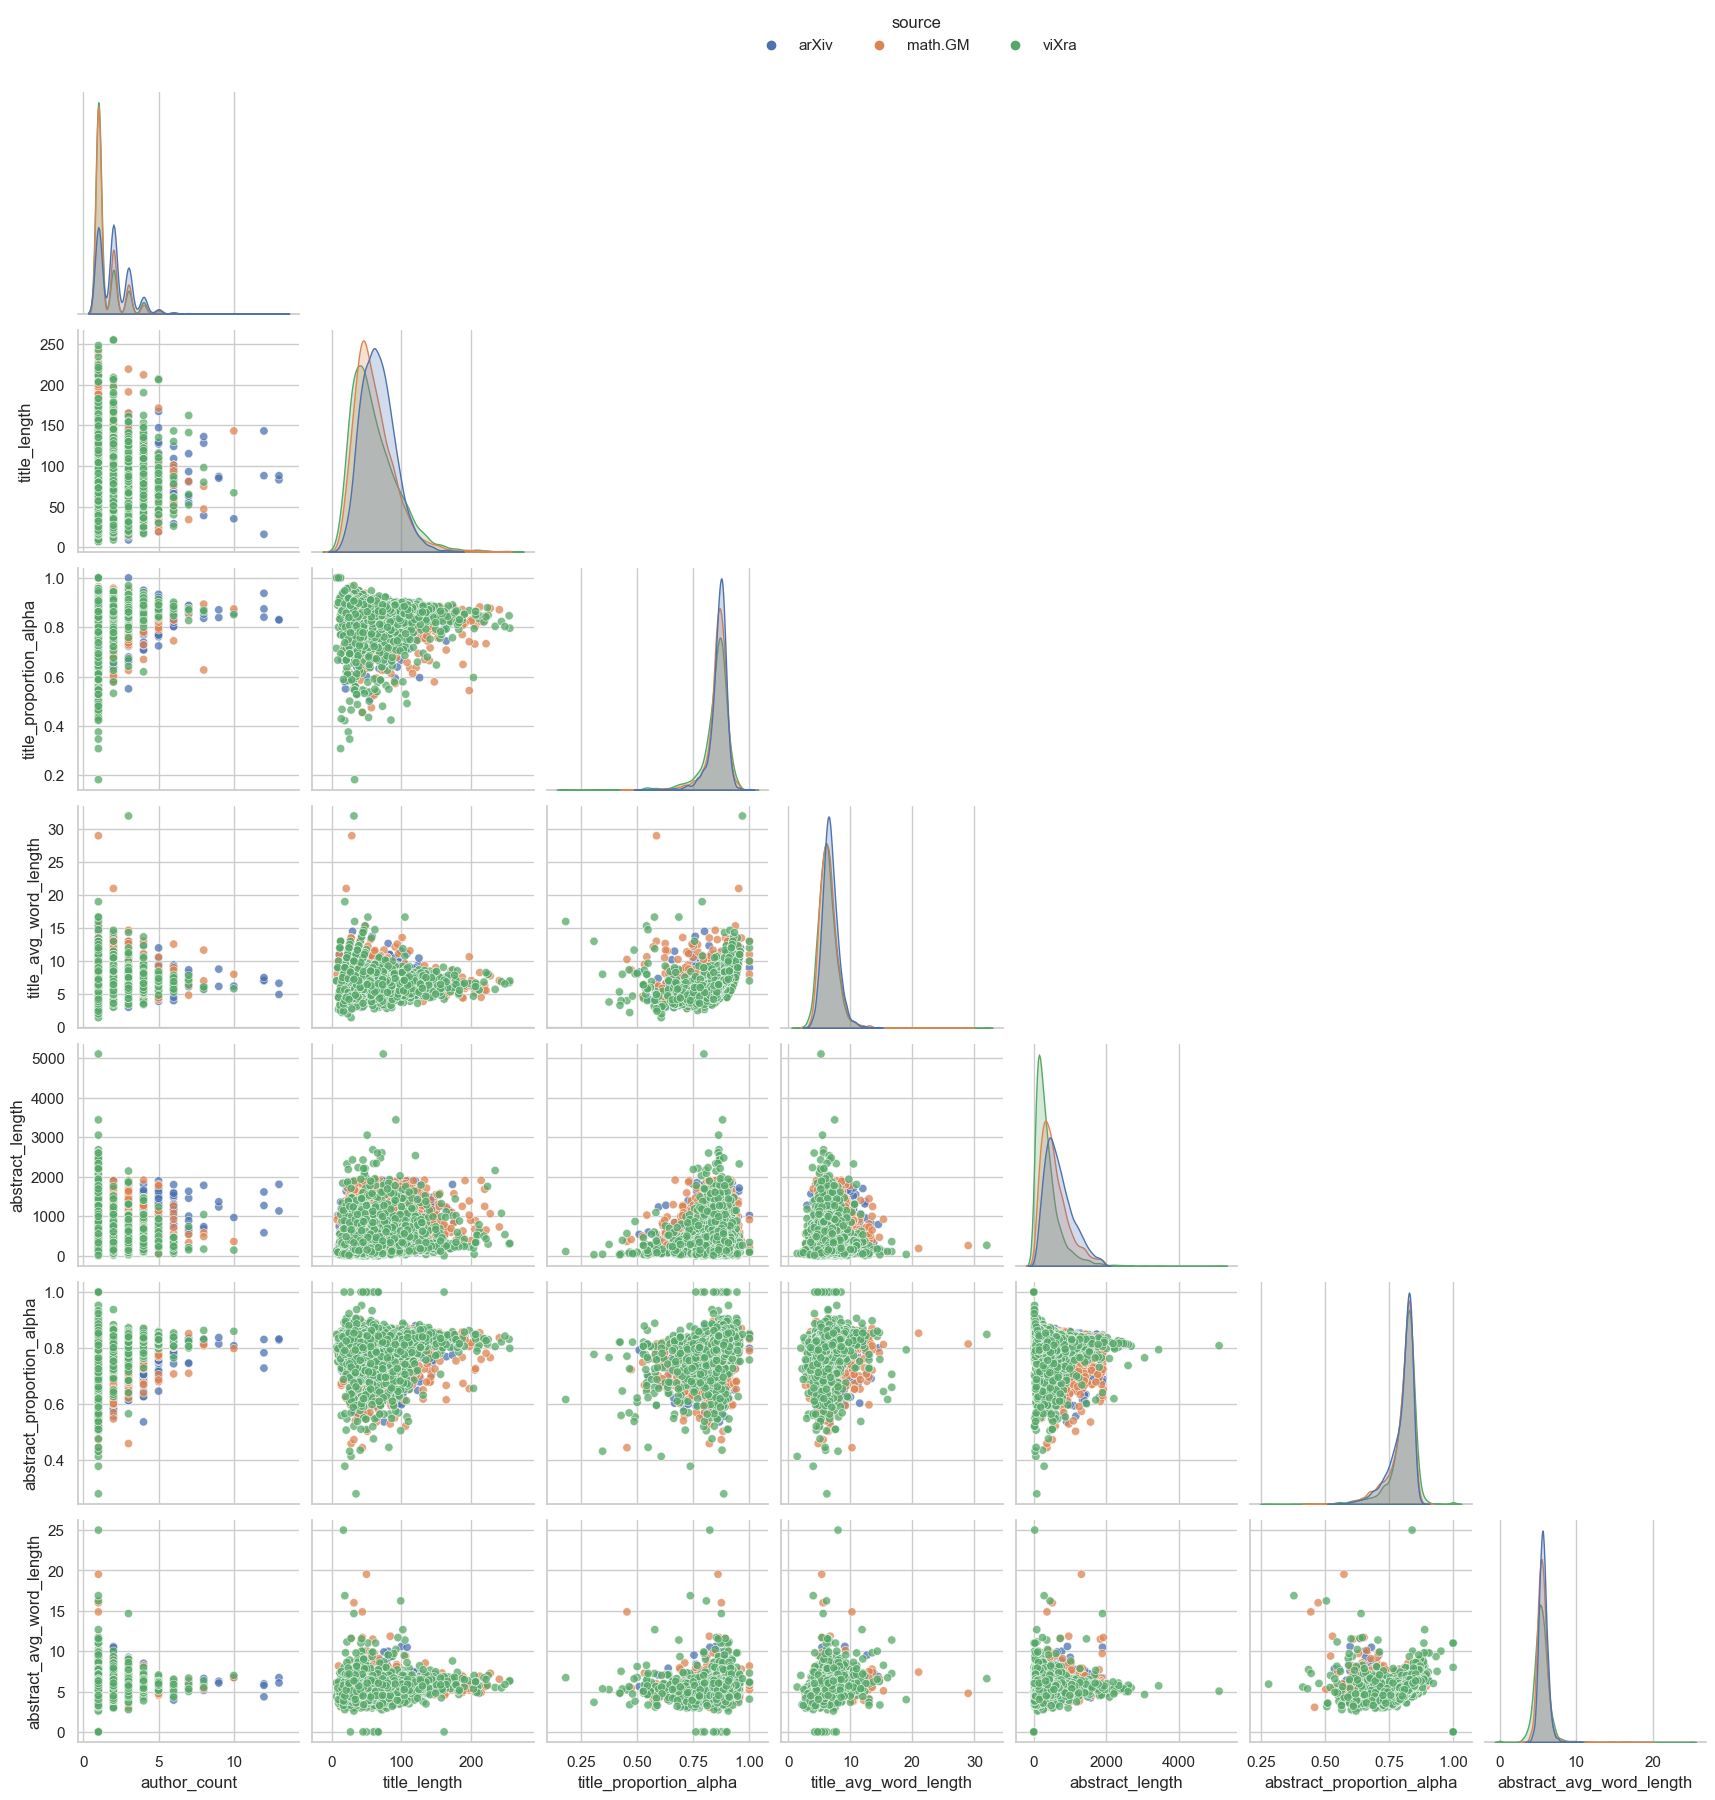

In [69]:
ax = sns.pairplot(numeric_balanced_df, 
                  hue="source",  
                  corner=True,
                  plot_kws=dict(alpha=0.75))
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5,1), ncol=3)

From this we can make some observations. 

- Articles from viXra and math.GM are more often than not written by a single author, while articles from arXiv proper are just as frequently written by one author as by two.
- The distributions of title length and abstract length shift right (longer) as we go from viXra to math.GM to arXiv proper.
- On the other hand, the distributions of the average word lengths and the proportions of alphabetical characters are very similar.

For these features, there are some differences between the articles from arXiv proper, math.GM, and viXra, but there is almost no separation of these groups. Interestingly, math.GM seems to be an intermediate between arXiv proper and viXra. To begin work on a classifier, one option would be to derive more syntactical features. However, this preliminary analysis suggests that an even better approach could be to instead use semantic features of the title and abstract.

# BERT model

In this section, we fine-tune BERT models to categorize articles as high or low quality. Articles from arXiv proper will constitute the training data for label 0 (high quality), while articles from viXra will constitute the training data for label 1 (low quality). We use the models to predict the probability of being low quality for every math.GM article, and find there is a bimodal distribution. Finally, we calculate optimal thresholds from the ROC curves using Youden's J statistic, and categorize the math.GM articles as high or low quality.

The models will be trained on the `title`, `abstract`, and `author_count` fields for each article, which we combine into one sentence (using the separator token \[SEP\]). In this way, we can use the full power of BERT on all of the available information.

We fine-tune four different models: `balanced`, `no_VGM_balanced`, `imbalanced`, and `no_VGM_imbalanced` to adress two potential concerns. One is that the dataset is heavily imbalanced with more than 50 times more arXiv articles than viXra articles. We train `balanced` and `no_VGM_balanced` on a balanced sample of the data and `imbalanced` and `no_VGM_imbalanced` on an imbalanced sample (10:1). The second is that by including the General Mathematics category in the viXra dataset, we might be training the model to predict whether an article belongs to the "General Mathematics" category instead of whether an article is of low quality. In that case, it would not be too much of a surprise if it categorized articles from math.GM as belonging to the same group as the viXra General Mathematics category. To combat that, we train `no_VGM_balanced` and `no_VGM_imbalanced` on data that does not include the viXra General Mathematics category.

We load the data from the SQL Server into pandas DataFrames.

In [13]:
arxiv_data = cursor.execute("""
    SELECT title, abstract, author_count
    FROM arxiv_articles
    WHERE primary_category <> ?;
""", "math.GM").fetchall()
arxiv_df = pd.DataFrame.from_records(arxiv_data, columns = ["title", "abstract", "author_count"])
arxiv_df["author_count"] = arxiv_df["author_count"].astype(str)
arxiv_df["label"] = 0
print(f"arxiv_df : {len(arxiv_df.index)} rows")

arxiv_gm_data = cursor.execute("""
    SELECT title, abstract, author_count
    FROM arxiv_articles
    WHERE primary_category = ?;
""", "math.GM").fetchall()
arxiv_gm_df = pd.DataFrame.from_records(arxiv_gm_data, columns = ["title", "abstract", "author_count"])
arxiv_gm_df["author_count"] = arxiv_gm_df["author_count"].astype(str)
arxiv_gm_df["label"] = 0
print(f"arxiv_gm_df : {len(arxiv_gm_df.index)} rows")

vixra_full_data = cursor.execute("""
    SELECT title, abstract, author_count
    FROM vixra_articles
        INNER JOIN 
            (
            SELECT a.id AS id, COUNT(b.id) AS author_count
            FROM vixra_articles a 
                INNER JOIN vixra_articles_authors b 
                ON a.id = b.article_id
            GROUP BY a.id
            ) AS vixra_author_counts
        ON vixra_articles.id = vixra_author_counts.id;
""").fetchall()
vixra_full_df = pd.DataFrame.from_records(vixra_full_data, columns = ["title", "abstract", "author_count"])
vixra_full_df["author_count"] = vixra_full_df["author_count"].astype(str)
vixra_full_df["label"] = 1
print(f"vixra_full_df : {len(vixra_full_df.index)} rows")

vixra_no_gm_data = cursor.execute("""
    SELECT title, abstract, author_count
    FROM vixra_articles
        INNER JOIN 
            (
            SELECT a.id AS id, COUNT(b.id) AS author_count
            FROM vixra_articles a 
                INNER JOIN vixra_articles_authors b 
                ON a.id = b.article_id
            GROUP BY a.id
            ) AS vixra_author_counts
        ON vixra_articles.id = vixra_author_counts.id
    WHERE category <> ?;
""", "math").fetchall()
vixra_no_gm_df = pd.DataFrame.from_records(vixra_no_gm_data, columns = ["title", "abstract", "author_count"])
vixra_no_gm_df["author_count"] = vixra_no_gm_df["author_count"].astype(str)
vixra_no_gm_df["label"] = 1
print(f"vixra_no_gm_df : {len(vixra_no_gm_df.index)} rows")


arxiv_df : 518771 rows
arxiv_gm_df : 3401 rows
vixra_full_df : 8890 rows
vixra_no_gm_df : 5601 rows


For each model, we take a sample of the data as described above, and then split them into train, val, and test sets.

In [14]:
model_names = ["balanced", "no_VGM_balanced", "imbalanced", "no_VGM_imbalanced"]

def get_imbalanced_sample(data, column_name, group_biases):
    groups = data.groupby(column_name)
    unit_size = np.floor((groups.size().astype(np.float64) / pd.Series(group_biases)).min())
    assert(unit_size >= 0)
    return groups.apply(lambda x : x.sample((group_biases[x.name] * unit_size).astype(int))).reset_index(drop = True)

BIAS_FACTOR = 10

dfs = {"balanced" : get_imbalanced_sample(pd.concat([arxiv_df, vixra_full_df]), "label", {0 : 1, 1 : 1}),
       "no_VGM_balanced" : get_imbalanced_sample(pd.concat([arxiv_df, vixra_no_gm_df]), "label", {0 : 1, 1 : 1}),
       "imbalanced" : get_imbalanced_sample(pd.concat([arxiv_df, vixra_full_df]), "label", {0 : BIAS_FACTOR, 1 : 1}),
       "no_VGM_imbalanced" : get_imbalanced_sample(pd.concat([arxiv_df, vixra_no_gm_df]), "label", {0 : BIAS_FACTOR, 1 : 1})
      }

In [15]:
def get_datasets_from_dataframe(df, feature_columns, label_column, batch_size, prefetch_size, train_split = 0.8, val_split = 0.1, shuffle = True):
    
    size = len(df.index)
    
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)
    
    labels = df.pop(label_column)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    
    train_size = int(train_split * size)
    val_size = int(val_split * size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=prefetch_size)
    val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=prefetch_size)
    test_ds = test_ds.batch(batch_size).cache().prefetch(buffer_size=prefetch_size)
    
    return train_ds, val_ds, test_ds

BATCH_SIZE = 32
PREFETCH_SIZE = tf.data.AUTOTUNE

train_dss = {}
val_dss = {}
test_dss = {}

for name in model_names:
    train_dss[name], val_dss[name], test_dss[name] = get_datasets_from_dataframe(dfs[name],
                                                                                 feature_columns=["title", "abstract", "author_count"], 
                                                                                 label_column="label", 
                                                                                 batch_size=BATCH_SIZE, 
                                                                                 prefetch_size=PREFETCH_SIZE)

Now, we define the model. We fine-tune a BERT model (size chosen due to processing constraints). As part of the preprocessing stage, we need to define our own preprocessing layer to combine `author_count`, `title`, and `abstract` into a single BERT input.

In [16]:
BERT_ENCODER = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
BERT_PREPROCESSOR = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

def interleave(xlist, item):
    L = len(xlist)
    if L <= 1:
        return xlist
    result = [item] * (2*L - 1)
    result[0::2] = xlist
    return result

class ConcatBERTPreprocessor(tf.keras.layers.Layer):
    def __init__(self, bert_preprocessor_url, seq_length, **kwargs):
        self.seq_length = seq_length
        self.bert_preprocessor_url = bert_preprocessor_url
        self.preprocessor = hub.load(self.bert_preprocessor_url)
        self.tokenize = hub.KerasLayer(self.preprocessor.tokenize)
        self.SEP_TOKEN_ID = self.preprocessor.tokenize.get_special_tokens_dict()["end_of_segment_id"].numpy()
        self.pack_inputs = hub.KerasLayer(self.preprocessor.bert_pack_inputs, arguments=dict(seq_length=self.seq_length))
        super().__init__(**kwargs)
        
    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        SEP_TENSOR = tf.fill([batch_size, 1, 1], self.SEP_TOKEN_ID)
        tokenized_list = [self.tokenize(segment) for segment in inputs]
        interleaved_list = interleave(tokenized_list, SEP_TENSOR)
        prepacked = tf.concat(interleaved_list, axis=1)
        encoder_inputs = self.pack_inputs([prepacked])
        return encoder_inputs
    
def build_BERT_classifier_model():
  text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string, name="author_count"),
                 tf.keras.layers.Input(shape=(), dtype=tf.string, name="title"),
                 tf.keras.layers.Input(shape=(), dtype=tf.string, name="abstract")]
  preprocessing_layer = ConcatBERTPreprocessor(BERT_PREPROCESSOR, seq_length=128, name="preprocessing")
  encoder_inputs = preprocessing_layer(text_inputs)
  encoder = hub.KerasLayer(BERT_ENCODER, trainable=True, name="BERT_encoder")
  outputs = encoder(encoder_inputs)
  net = outputs["pooled_output"]
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name="classifier")(net)
  return tf.keras.Model(text_inputs, net)

BERT_classifier = build_BERT_classifier_model()

We define the training parameters, which are relatively standard for BERT fine-tuning as suggested in the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf). For BERT fine-tuning tasks, only a few epochs are necessary before overfitting begins. They suggest 2-4 epochs, but we found we could only get away with a single epoch for the smaller balanced datasets.

For the imbalanced datasets, we make sure to include their relative weights into the loss function by using `class_weights`.

In [17]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def binary_mcc(y_true, y_pred):
    predicted = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    tp = tf.math.count_nonzero(predicted * y_true)
    tn = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
    fp = tf.math.count_nonzero(predicted * (y_true - 1))
    fn = tf.math.count_nonzero((predicted - 1) * y_true)
    x = tf.cast((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn), tf.float32)
    if x == 0:
        x = 1.0
    return tf.cast((tp * tn) - (fp * fn), tf.float32) / tf.sqrt(x)
    
metrics = [binary_mcc, 
           tf.keras.metrics.AUC(from_logits=True, name="auroc"),
           tf.keras.metrics.AUC(curve="PR", from_logits=True, name="auprc")
          ]
                                
weighted_metrics = ["accuracy"]

epochss = {"balanced" : 1,
           "no_VGM_balanced" : 1,
           "imbalanced" : 2,
           "no_VGM_imbalanced" : 2
          }
                                
warmup_ratio = 0.1
init_lr = 3e-5

def get_optimizer(train_ds, epochs, warmup_ratio, init_lr):
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(warmup_ratio * num_train_steps)
    return optimization.create_optimizer(init_lr = init_lr,
                                         num_train_steps = num_train_steps,
                                         num_warmup_steps = num_warmup_steps,
                                         optimizer_type="adamw")
                                
optimizers = {name : get_optimizer(train_dss[name], epochss[name], warmup_ratio, init_lr) for name in model_names}

class_weights = {"balanced" : {0 : 1, 1 : 1},
                 "no_VGM_balanced" : {0 : 1, 1 : 1},
                 "imbalanced" : {0 : 1, 1 : BIAS_FACTOR},
                 "no_VGM_imbalanced" : {0 : 1, 1 : BIAS_FACTOR}
                }


save_paths = {"balanced" : "./model_weights/balanced",
              "no_VGM_balanced" : "./model_weights/no_VGM_balanced",
              "imbalanced" : "./model_weights/imbalanced",
              "no_VGM_imbalanced" : "./model_weights/no_VGM_imbalanced"
             }

Now, we fine-tune the models and also perform all of the required predictions.

In [18]:
histories = {}
test_evals = {}
test_preds = {name : pd.DataFrame(data=np.concatenate([label for _, label in test_dss[name]], axis=0), columns=["label"]) for name in model_names}

RESAMPLE_SIZE = 25000
arxiv_resample_df = arxiv_df.sample(RESAMPLE_SIZE).reset_index(drop=True)
full_imbalanced_sample_df = get_imbalanced_sample(pd.concat([arxiv_df, vixra_full_df]), "label", {0 : 5, 1 : 1})
for name in model_names:
    print(f"Training {name} model by fine-tuning ({BERT_ENCODER}).")

    BERT_classifier.compile(optimizer=optimizers[name],
                            loss=loss,
                            metrics=metrics,
                            weighted_metrics=weighted_metrics)

    histories[name] = BERT_classifier.fit(x=train_dss[name],
                                          validation_data=val_dss[name],
                                          class_weight=class_weights[name],
                                          epochs=epochss[name])

    BERT_classifier.save(save_paths[name])
    print(f"{name} model trained and saved.\n")
    
    print(f"Evaluating on {name} test set...")
    test_evals[name] = BERT_classifier.evaluate(test_dss[name])
    print(f"Predicting on {name} test set...")
    test_preds[name]["pred"] = tf.sigmoid(BERT_classifier.predict(test_dss[name]))
    print(f"Predicting on arxiv_gm...")
    arxiv_gm_df[name + "_pred"] = tf.sigmoid(BERT_classifier.predict(dict(arxiv_gm_df[["title", "abstract", "author_count"]])))
    print(f"Predicting on arxiv_resample...")
    arxiv_resample_df[name + "_pred"] = tf.sigmoid(BERT_classifier.predict(dict(arxiv_resample_df[["title", "abstract", "author_count"]])))
    print(f"Predicting on vixra_full...")
    vixra_full_df[name + "_pred"] = tf.sigmoid(BERT_classifier.predict(dict(vixra_full_df[["title", "abstract", "author_count"]])))
    print(f"Predicting on full_imbalanced_sample...")
    full_imbalanced_sample_df[name + "_pred"] = tf.sigmoid(BERT_classifier.predict(dict(full_imbalanced_sample_df[["title", "abstract", "author_count"]])))
    print("\n")

Training balanced model by fine-tuning (https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1).
445/445 [==============================] - 192s 411ms/step - loss: 0.2799 - binary_mcc: 0.7542 - auroc: 0.9519 - auprc: 0.9550 - accuracy: 0.8748 - val_loss: 0.1800 - val_binary_mcc: 0.8534 - val_auroc: 0.9809 - val_auprc: 0.9807 - val_accuracy: 0.9274


INFO:tensorflow:Assets written to: ./model_weights/balanced\assets


INFO:tensorflow:Assets written to: ./model_weights/balanced\assets


balanced model trained and saved.

Evaluating on balanced test set...
56/56 [==============================] - 11s 195ms/step - loss: 0.1872 - binary_mcc: 0.8658 - auroc: 0.9781 - auprc: 0.9787 - accuracy: 0.9331
Predicting on balanced test set...
56/56 [==============================] - 12s 193ms/step
Predicting on arxiv_gm...
107/107 [==============================] - 21s 191ms/step
Predicting on arxiv_resample...
782/782 [==============================] - 154s 197ms/step
Predicting on vixra_full...
278/278 [==============================] - 59s 211ms/step
Predicting on full_imbalanced_sample...
1667/1667 [==============================] - 343s 205ms/step


Training no_VGM_balanced model by fine-tuning (https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1).
281/281 [==============================] - 130s 435ms/step - loss: 0.2096 - binary_mcc: 0.8285 - auroc: 0.9740 - auprc: 0.9746 - accuracy: 0.9153 - val_loss: 0.1839 - val_binary_mcc: 0.8663 - val_auroc: 0.9798 -

INFO:tensorflow:Assets written to: ./model_weights/no_VGM_balanced\assets


INFO:tensorflow:Assets written to: ./model_weights/no_VGM_balanced\assets


no_VGM_balanced model trained and saved.

Evaluating on no_VGM_balanced test set...
36/36 [==============================] - 7s 199ms/step - loss: 0.1511 - binary_mcc: 0.8561 - auroc: 0.9856 - auprc: 0.9867 - accuracy: 0.9402
Predicting on no_VGM_balanced test set...
36/36 [==============================] - 8s 197ms/step
Predicting on arxiv_gm...
107/107 [==============================] - 23s 200ms/step
Predicting on arxiv_resample...
782/782 [==============================] - 160s 205ms/step
Predicting on vixra_full...
278/278 [==============================] - 55s 198ms/step
Predicting on full_imbalanced_sample...
1667/1667 [==============================] - 335s 201ms/step


Training imbalanced model by fine-tuning (https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1).
Epoch 1/2
2445/2445 [==============================] - 1039s 422ms/step - loss: 0.4595 - binary_mcc: 0.7501 - auroc: 0.9763 - auprc: 0.8875 - accuracy: 0.9096 - val_loss: 0.0703 - val_binary_mcc: 0

INFO:tensorflow:Assets written to: ./model_weights/imbalanced\assets


INFO:tensorflow:Assets written to: ./model_weights/imbalanced\assets


imbalanced model trained and saved.

Evaluating on imbalanced test set...
306/306 [==============================] - 76s 249ms/step - loss: 0.0945 - binary_mcc: 0.8289 - auroc: 0.9772 - auprc: 0.9012 - accuracy: 0.9778
Predicting on imbalanced test set...
306/306 [==============================] - 73s 231ms/step
Predicting on arxiv_gm...
107/107 [==============================] - 26s 227ms/step
Predicting on arxiv_resample...
782/782 [==============================] - 179s 229ms/step
Predicting on vixra_full...
278/278 [==============================] - 60s 215ms/step
Predicting on full_imbalanced_sample...
1667/1667 [==============================] - 342s 205ms/step


Training no_VGM_imbalanced model by fine-tuning (https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1).
Epoch 1/2
1541/1541 [==============================] - 642s 412ms/step - loss: 0.3959 - binary_mcc: 0.8099 - auroc: 0.9813 - auprc: 0.9093 - accuracy: 0.9329 - val_loss: 0.0861 - val_binary_mcc: 0.84

INFO:tensorflow:Assets written to: ./model_weights/no_VGM_imbalanced\assets


INFO:tensorflow:Assets written to: ./model_weights/no_VGM_imbalanced\assets


no_VGM_imbalanced model trained and saved.

Evaluating on no_VGM_imbalanced test set...
193/193 [==============================] - 41s 210ms/step - loss: 0.0890 - binary_mcc: 0.8601 - auroc: 0.9756 - auprc: 0.9094 - accuracy: 0.9813
Predicting on no_VGM_imbalanced test set...
193/193 [==============================] - 40s 203ms/step
Predicting on arxiv_gm...
107/107 [==============================] - 22s 196ms/step
Predicting on arxiv_resample...
782/782 [==============================] - 160s 204ms/step
Predicting on vixra_full...
278/278 [==============================] - 55s 198ms/step
Predicting on full_imbalanced_sample...
1667/1667 [==============================] - 336s 202ms/step




Let's evaluate the performance of the models by looking at their PR curves and AOC curves. Since the test sets for each model are different, it is difficult to compare their performance. So, we also include their performance on a common dataset, an imbalanced sample of articles from arXiv proper and viXra. Note this performance is not statistically robust since the models will likely have been trained on parts of the common dataset. However, it is a trade off we made to have a larger set of positive training examples.

In [19]:
rows = []
for name in model_names:
    ap = sklearn.metrics.average_precision_score(test_preds[name]["label"], test_preds[name]["pred"])
    rows.append({"model" : name, "dataset" : "test", "ap_score" : ap})
    
    ap = sklearn.metrics.average_precision_score(full_imbalanced_sample_df["label"], full_imbalanced_sample_df[name + "_pred"])
    rows.append({"model" : name, "dataset" : "full_imbalanced_sample", "ap_score" : ap})
    
apscores_df = pd.DataFrame(rows)
apscores_df.pivot(columns="model", index="dataset")

ap_score                                             
model                   balanced imbalanced no_VGM_balanced no_VGM_imbalanced
dataset                                                                      
full_imbalanced_sample  0.938506   0.979554        0.948358          0.983841
test                    0.978025   0.947352        0.986887          0.958598

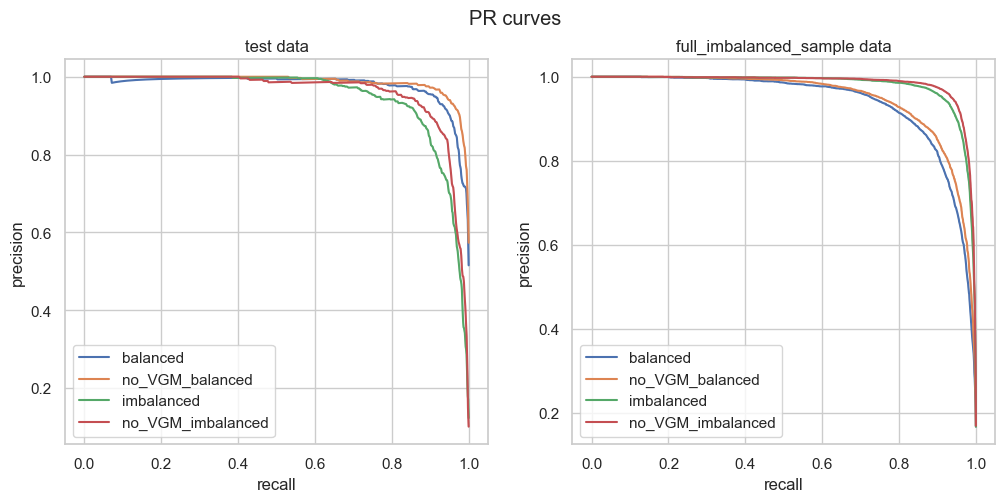

In [20]:
_, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,5))
plt.suptitle("PR curves")
for name in model_names:
    precision, recall, _ = sklearn.metrics.precision_recall_curve(test_preds[name]["label"], test_preds[name]["pred"])
    sns.lineplot(data={"precision" : precision, "recall" : recall}, x = "recall", y = "precision", label=name, ax=ax1)
    ax1.set(title="test data")
    
    precision, recall, _ = sklearn.metrics.precision_recall_curve(full_imbalanced_sample_df["label"], full_imbalanced_sample_df[name + "_pred"])
    sns.lineplot(data={"precision" : precision, "recall" : recall}, x = "recall", y = "precision", label=name, ax=ax2)
    ax2.set(title="full_imbalanced_sample data")

In [21]:
rows = []
for name in model_names:
    auc = sklearn.metrics.roc_auc_score(test_preds[name]["label"], test_preds[name]["pred"])
    rows.append({"model" : name, "dataset" : "test", "auroc" : auc})
    
    auc = sklearn.metrics.roc_auc_score(full_imbalanced_sample_df["label"], full_imbalanced_sample_df[name + "_pred"])
    rows.append({"model" : name, "dataset" : "full_imbalanced_sample", "auroc" : auc})
    
auroc_df = pd.DataFrame(rows)
auroc_df.pivot(columns="model", index="dataset")

auroc                                             
model                   balanced imbalanced no_VGM_balanced no_VGM_imbalanced
dataset                                                                      
full_imbalanced_sample  0.981798   0.994336        0.985380          0.995507
test                    0.977973   0.990290        0.985689          0.992318

While graphing the ROC curves, we also use Youden's J statistic (J = tpr - fpr) to calculate an optimal threshold for each model.

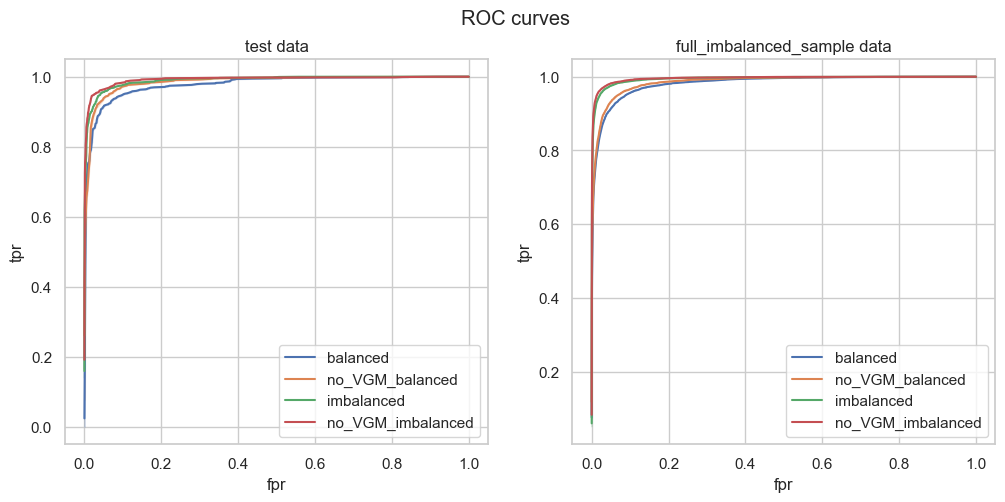

In [22]:
_, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,5))
plt.suptitle("ROC curves")
optimal_thresholds = {}
for name in model_names:
    fpr, tpr, _ = sklearn.metrics.roc_curve(test_preds[name]["label"], test_preds[name]["pred"])
    sns.lineplot(data={"fpr" : fpr, "tpr" : tpr}, x = "fpr", y = "tpr", label=name, ax=ax1)
    ax1.set(title="test data")
    
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(full_imbalanced_sample_df["label"], full_imbalanced_sample_df[name + "_pred"])
    sns.lineplot(data={"fpr" : fpr, "tpr" : tpr}, x = "fpr", y = "tpr", label=name, ax=ax2)
    ax2.set(title="full_imbalanced_sample data")
    J = tpr - fpr
    optimal_thresholds[name] = thresholds[np.argmax(J)]

In [23]:
optimal_thresholds

{'balanced': 0.58601,
 'no_VGM_balanced': 0.51715857,
 'imbalanced': 0.03259042,
 'no_VGM_imbalanced': 0.017329857}

Now, let's take a look at the distribution of predictions for each model on the math.GM articles. For every model, we find a bimodal distribution (whether viXra General Mathematics articles were included or not seems to have a minimal effect), and for the models trained on the imbalanced datasets we see a significant separation.

Text(0.5, 1.0, "Predictions on arXiv's math.GM category")

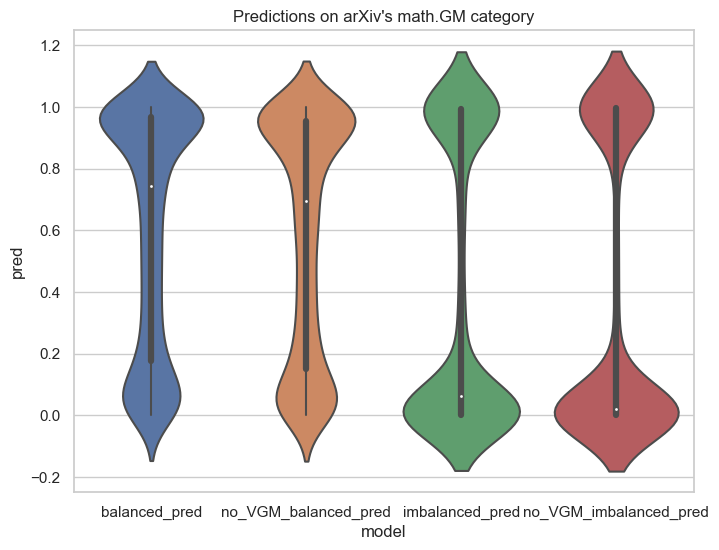

In [24]:
arxiv_gm_melted_df = arxiv_gm_df[[name + "_pred" for name in model_names]].melt(var_name = "model", value_name = "pred")
plt.figure(figsize=(8,6))
sns.violinplot(data=arxiv_gm_melted_df, x = "model", y="pred").set_title("Predictions on arXiv's math.GM category")

For consistency, we look at the distributions of predictions for each model on a resampled arXiv proper dataset and the full viXra dataset. We see that every model has a unimodal distribution for the arxiv_resample dataset (concentrated at 0) and the vixra_full dataset (concentrated at 1).

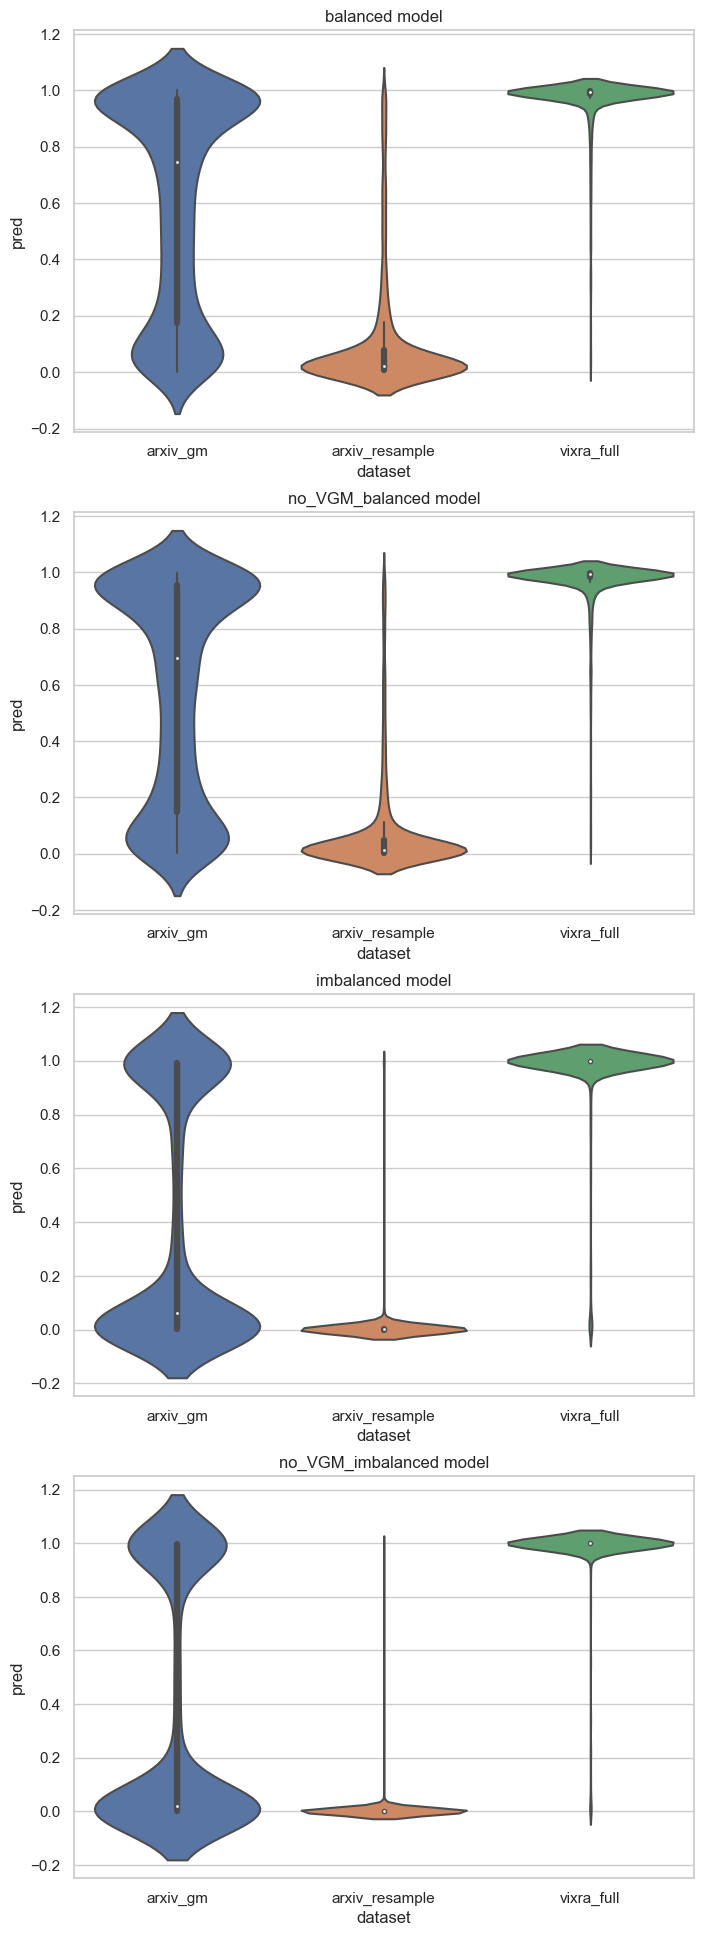

In [25]:
_, axs = plt.subplots(len(model_names), 1, figsize=(8,24))
for name_index, name in enumerate(model_names):
    inner_df = pd.DataFrame()
    inner_df["arxiv_gm"] = arxiv_gm_df[name + "_pred"]
    inner_df["arxiv_resample"] = arxiv_resample_df[name + "_pred"]
    inner_df["vixra_full"] = vixra_full_df[name + "_pred"]
    melted_df = inner_df.melt(var_name = "dataset", value_name = "pred")
    sns.violinplot(data=melted_df, x = "dataset", y = "pred", ax = axs[name_index], scale="width")
    axs[name_index].set(title=name + " model")

We use the optimal thresholds determined above, and actually categorize the math.GM articles accordingly. No matter the model, we see a huge proportion of math.GM articles are categorized as low quality (label 1) while the arXiv proper and viXra articles are categorized generally in the correct category.

Text(0.5, 1.0, "Classification of arXiv's math.GM category")

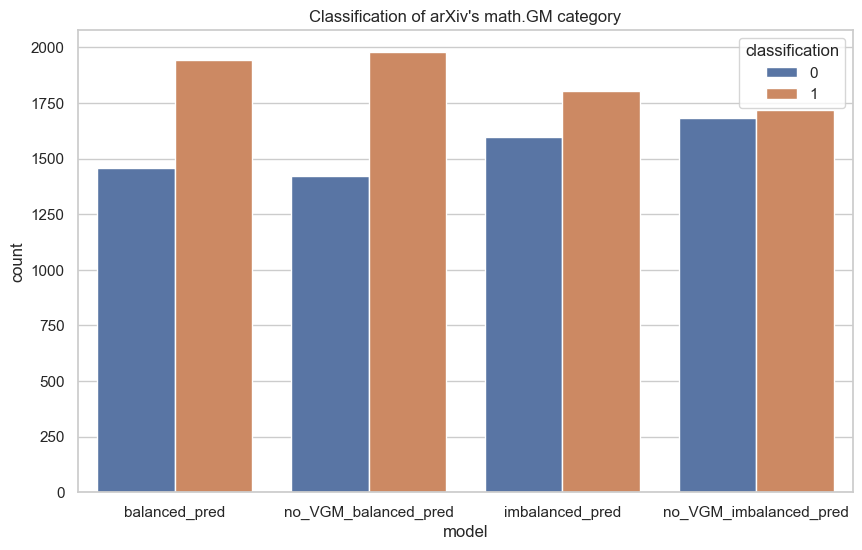

In [40]:
arxiv_gm_countplot_df = pd.DataFrame()
for name in model_names:
    arxiv_gm_countplot_df[name] = arxiv_gm_df[name + "_pred"]
arxiv_gm_countplot_df = arxiv_gm_countplot_df.melt(var_name = "model", value_name = "pred")
arxiv_gm_countplot_df["classification"] = arxiv_gm_countplot_df.apply(lambda x : int(x["pred"] > optimal_thresholds[x["model"]]), axis=1)
plt.figure(figsize=(10,6))
sns.countplot(data=arxiv_gm_melted_df, x="model", hue="classification").set_title("Classification of arXiv's math.GM category")

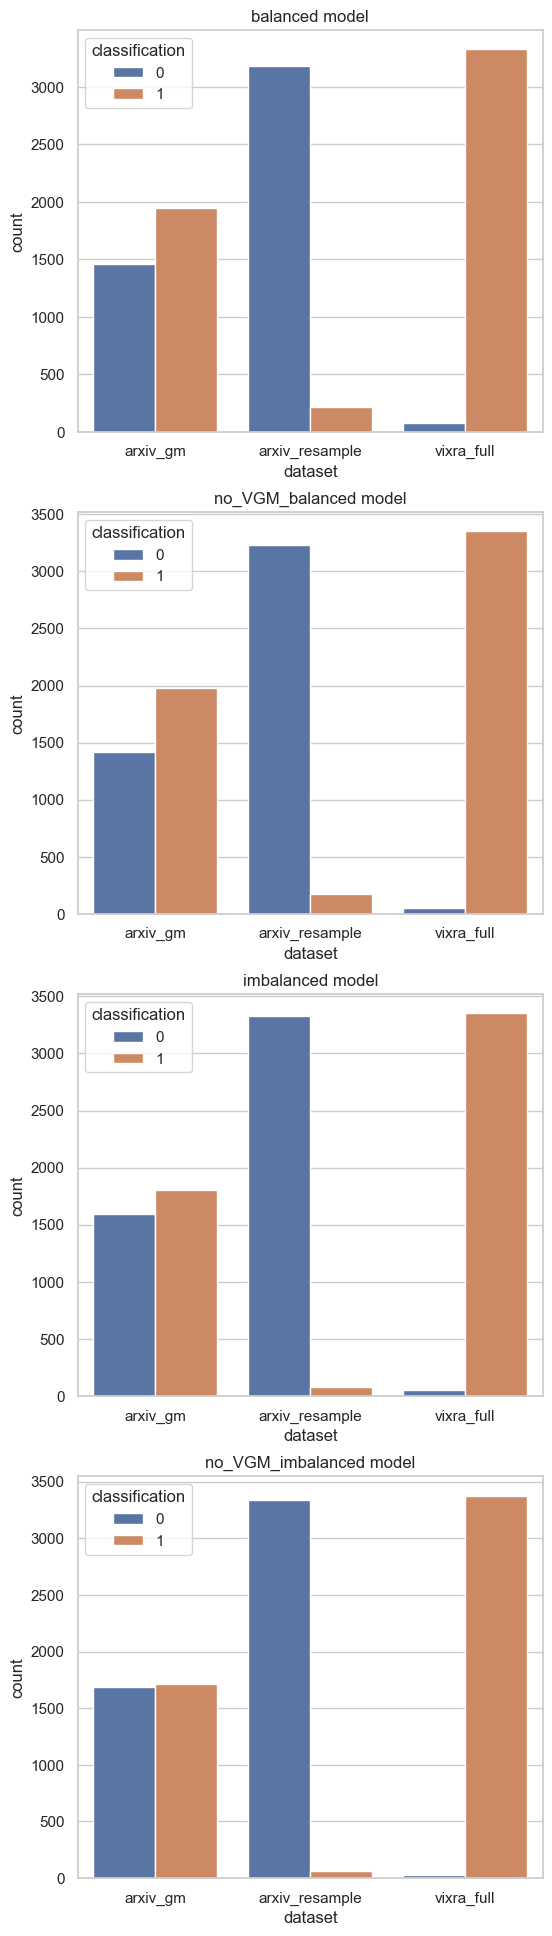

In [37]:
_, axs = plt.subplots(len(model_names), 1, figsize=(6,24))
for name_index, name in enumerate(model_names):
    inner_df = pd.DataFrame()
    inner_df["arxiv_gm"] = arxiv_gm_df[name + "_pred"]
    inner_df["arxiv_resample"] = arxiv_resample_df[name + "_pred"]
    inner_df["vixra_full"] = vixra_full_df[name + "_pred"]
    melted_df = inner_df.melt(var_name = "dataset", value_name = "pred")
    melted_df["classification"] = melted_df["pred"].apply(lambda x : int(x > optimal_thresholds[name]))
    sns.countplot(data=melted_df, x="dataset", hue="classification", ax=axs[name_index])
    axs[name_index].set(title=name + " model")

In [ ]:
cursor.close()
cnxn.close()